In [0]:
!sudo apt install tesseract-ocr
!pip install pytesseract

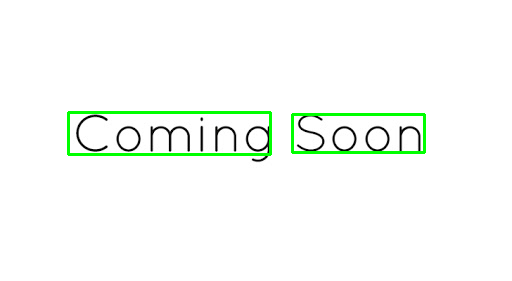

-1

In [93]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2
from google.colab.patches import cv2_imshow

#Loading the Input Image & Dimensions of Image

image = cv2.imread('/content/coming.jpg') #Location of the IMG File
orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height

(newW, newH) = (640, 320)
rW = W / float(newW)
rH = H / float(newH)

# Resizing & Grabbing Dimensions of Image

image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

#Layer1=Probabilistic Layer2=Coordinates for Drawn Boxes

layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

#Loading Pretrained East Detector

net = cv2.dnn.readNet('/frozen_east_text_detection.pb') #Location Of frozen_east.db file

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets

blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5 :
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
  # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

#apply non-maxima suppression to suppress weak, overlapping bounding  boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

cv2_imshow(orig)
cv2.waitKey(0)

Comino

Soon



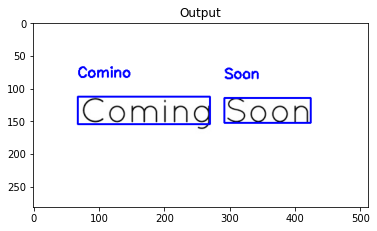

In [90]:


import pytesseract
import matplotlib.pyplot as plt

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))

#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()

